In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import optimizers, Sequential, Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from numpy.random import seed
from matplotlib.pylab import rcParams
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed

Using TensorFlow backend.
D:\xiaoke\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\xiaoke\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\xiaoke\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\xiaoke\Anaconda3\envs\tensorflow1\lib\sit

In [2]:
seed(7)
set_random_seed(11)
# tf.random.set_seed(11)

# used to help randomly select the data points
SEED = 123
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal", "Break"]

'''
Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdyUk3lfDl7I5KYK_pw285LCApc-_RcoC0Tf9cnDnZ_TWzPAw/viewform
'''
df = pd.read_csv("E:\WithWeng\lstm\data\processminer-rare-event-mts - data.csv")
df.head(n=5)  # visualize the data.

sign = lambda x: (1, -1)[x < 0]


In [3]:

def curve_shift(df, shift_by):
    """
    将异常标记上移/下移shift行，并且去除原始异常标记行，即删除异常进行时只标记异常发生前/后的几秒作为异常
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s.
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.

    Inputs:
    df       A pandas dataframe with a binary labeled column.
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.

    Output
    df       A dataframe with the binary labels shifted by shift.

    这个函数是用来偏移数据中的二分类标签。
    平移只针对标签为 1 的数据
    举个例子，如果偏移量为 -2，下面的处理将会发生：
    如果是 n 行的标签为 1，那么
    - 使 (n+shift_by):(n+shift_by-1) = 1
    - 删除第 n 行。
    也就是说标签会上移 2 行。

    输入：
    df       一个分类标签列的 pandas 数据。
             这个标签列的名字是 ‘y’。
    shift_by 一个整数，表示要移动的行数。

    输出：
    df       按照偏移量平移过后的数据。
    """

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))  # shift函数是对数据进行移动的操作
        tmp = tmp.fillna(0)  # Nah的地方填充0
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol + 'tmp', value=vector)
    # Remove the rows with labelcol == 1.去掉原始异常项
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol + 'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [4]:
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
print(df.iloc[(one_indexes[0] - 3):(one_indexes[0] + 2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
# df = curve_shift(df, shift_by = -2)


print('After shifting')  # Validating if the shift happened correctly.
print(df.iloc[(one_indexes[0] - 4):(one_indexes[0] + 1), 0:5].head(n=5))

# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

Before shifting
             time  y        x1         x2         x3
256   5/1/99 8:32  0  1.016235  -4.058394  -1.097158
257   5/1/99 8:34  0  1.005602  -3.876199  -1.074373
258   5/1/99 8:36  0  0.933933  -3.868467  -1.249954
259   5/1/99 8:38  1  0.892311 -13.332664 -10.006578
260  5/1/99 10:50  0  0.020062  -3.987897  -1.248529
After shifting
            time  y        x1         x2         x3
255  5/1/99 8:30  0  0.997107  -3.865720  -1.133779
256  5/1/99 8:32  0  1.016235  -4.058394  -1.097158
257  5/1/99 8:34  0  1.005602  -3.876199  -1.074373
258  5/1/99 8:36  0  0.933933  -3.868467  -1.249954
259  5/1/99 8:38  1  0.892311 -13.332664 -10.006578


In [5]:
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values
print("input_X.shape:")
print(input_X.shape)
n_features = input_X.shape[1]  # number of features
print("n_features:")
print(n_features)

input_X.shape:
(18398, 59)
n_features:
59


In [6]:
# 切成时间片长为5，步长为1的时间片的集合
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    print(len(X))
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
            # print(np.shape(X[[(i+j+1)], :]))
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
    return output_X, output_y


In [7]:
'''
In LSTM, to make prediction at any time t, we will look at data from (t-lookback):t. In the following, we have an example to show how the input data are transformed with the `temporalize` function with `lookback=5`. For the modeling, we may use a longer lookback.
'''
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
print(df.iloc[(np.where(np.array(input_y) == 1)[0][0] - 5):(np.where(np.array(input_y) == 1)[0][0] + 1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X=input_X, y=input_y, lookback=lookback)
print("X.size")
print(np.shape(X))
print("y.size")
print(np.shape(y))

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
print(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0)))  # 输出shape：（5，59）,concatenate纵向拼接
print(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0)).shape)

# The two tables are the same. This testifies that we are correctly taking 5 samples (= lookback), X(t):X(t-5) to
# predict y(t). ## Divide the data into train, valid, and test

First instance of y = 1 in the original data
     y        x1         x2         x3        x4        x5         x6  \
254  0  0.975947  -3.913736  -1.304682  0.561987  0.004034  14.630532   
255  0  0.997107  -3.865720  -1.133779  0.377295 -0.219126  14.666420   
256  0  1.016235  -4.058394  -1.097158  2.327307 -0.442286  14.702309   
257  0  1.005602  -3.876199  -1.074373  0.844397 -0.553050  14.738228   
258  0  0.933933  -3.868467  -1.249954  2.875311 -0.500941  15.643990   
259  1  0.892311 -13.332664 -10.006578  2.855933 -0.448832  15.986336   

           x7        x8        x9  ...        x51        x52       x53  \
254  0.000732 -0.051043 -0.040129  ...  29.984624  11.257736 -0.752385   
255  0.000732 -0.061114 -0.040129  ...  29.984624  11.262375 -0.752385   
256  0.000732 -0.061114 -0.040129  ...  29.984624  11.267013 -0.752385   
257  0.000732 -0.061114 -0.030057  ...  29.984624  11.271652 -0.752385   
258  0.000732 -0.061114 -0.030057  ...  29.984624  11.276291 -0.752385   

In [8]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT,
                                                    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
print("X_train:")
print(X_train.shape)
print("X_valid:")
print(X_valid.shape)
print("X_test:")
print(X_test.shape)
print(type(X_train))

X_train_y0 = X_train[y_train == 0]
X_train_y1 = X_train[y_train == 1]

X_valid_y0 = X_valid[y_valid == 0]
X_valid_y1 = X_valid[y_valid == 1]
print("X_train_y0")
print(X_train_y0.shape)
print("X_train_y1")
print(X_train_y1.shape)
print("X_valid_y0")
print(X_valid_y0.shape)
print("X_valid_y1")
print(X_valid_y1.shape)


X_train:
(11770, 5, 1, 59)
X_valid:
(2943, 5, 1, 59)
X_test:
(3679, 5, 1, 59)
<class 'numpy.ndarray'>
X_train_y0
(11692, 5, 1, 59)
X_train_y1
(78, 5, 1, 59)
X_valid_y0
(2922, 5, 1, 59)
X_valid_y1
(21, 5, 1, 59)


In [9]:
# # Reshaping the data The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions
# corresponding to sample x lookback x features.
# #重塑数据 这里的张量是4维的。
# 我们将它们重塑为所需的3维，对应于样本x回溯x特征。
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [10]:
def flatten(X):
    """
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    """
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
        # print((X.shape[1] - 1))
    # print(flattened_X.shape)
    return (flattened_X)


def scale(X, scaler):
    """
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize

    Output
    X            Scaled 3D array.

    preprocessing这个模块还提供了一个实用类StandarScaler，它可以在训练数据集上做了标准转换操作之后，
    把相同的转换应用到测试训练集中。
    可以对训练数据，测试数据应用相同的转换，以后有新的数据进来也可以直接调用，不用再重新把数据放在一起再计算一次了。
    """
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])

    return X


# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))  # 用展平的X_train_y0训练StandardScaler转换器

X_train_y0_scaled = scale(X_train_y0, scaler)  # 标准化X_train_y0
X_train_y1_scaled = scale(X_train_y1, scaler)  # 标准化X_train_y1
X_train_scaled = scale(X_train, scaler)  # 标准化X_train

In [11]:
a = flatten(X_train_y0_scaled)  # 展平
print('colwise mean', np.mean(a, axis=0).round(6))  # 计算展平后均值
print('colwise variance', np.var(a, axis=0))  # 计算展平后方差

# The test succeeded. Now we will _scale_ the validation and test sets.
# 测试成功。 现在我们将缩放验证和测试集。
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

colwise mean [ 0.  0. -0.  0. -0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.
  0. -0. -0.  0. -0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
timesteps = X_train_y0_scaled.shape[1]  # equal to the lookback
n_features = X_train_y0_scaled.shape[2]  # 59

epochs = 200
batch = 64
lr = 0.0001

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# lstm_autoencoder.add()
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 32)             11776     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 59)             1947      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0
_________________________________________________________________


In [13]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                     save_best_only=True,
                     verbose=0)

tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                                                epochs=epochs,
                                                batch_size=batch,
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history


Train on 11692 samples, validate on 2922 samples
Epoch 1/200
 - 4s - loss: 1.1549 - val_loss: 0.9818
Epoch 2/200
 - 2s - loss: 1.0869 - val_loss: 0.8708
Epoch 3/200
 - 2s - loss: 0.9800 - val_loss: 0.7719
Epoch 4/200
 - 2s - loss: 0.8877 - val_loss: 0.6871
Epoch 5/200
 - 2s - loss: 0.8010 - val_loss: 0.6117
Epoch 6/200
 - 2s - loss: 0.7362 - val_loss: 0.5616
Epoch 7/200
 - 2s - loss: 0.6929 - val_loss: 0.5258
Epoch 8/200
 - 2s - loss: 0.6581 - val_loss: 0.4968
Epoch 9/200
 - 2s - loss: 0.6308 - val_loss: 0.4716
Epoch 10/200
 - 2s - loss: 0.6089 - val_loss: 0.4516
Epoch 11/200
 - 2s - loss: 0.5903 - val_loss: 0.4348
Epoch 12/200
 - 2s - loss: 0.5740 - val_loss: 0.4201
Epoch 13/200
 - 2s - loss: 0.5599 - val_loss: 0.4073
Epoch 14/200
 - 2s - loss: 0.5474 - val_loss: 0.3952
Epoch 15/200
 - 2s - loss: 0.5358 - val_loss: 0.3852
Epoch 16/200
 - 2s - loss: 0.5258 - val_loss: 0.3768
Epoch 17/200
 - 2s - loss: 0.5179 - val_loss: 0.3685
Epoch 18/200
 - 2s - loss: 0.5084 - val_loss: 0.3614
Epoch 

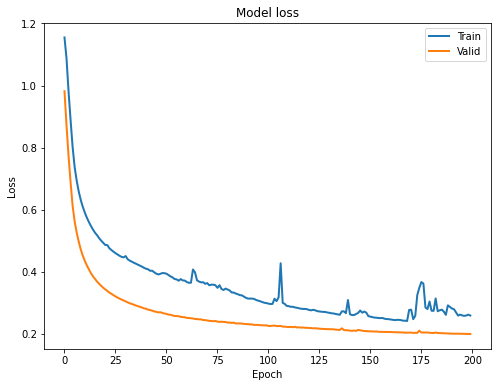

In [14]:
# plt show
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


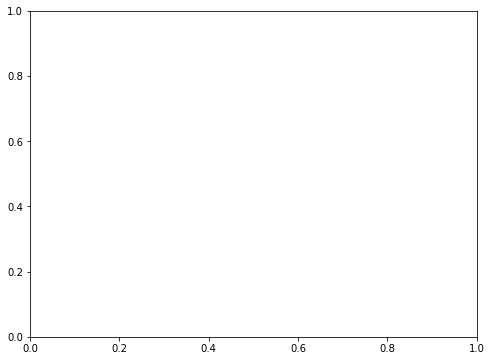

In [15]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

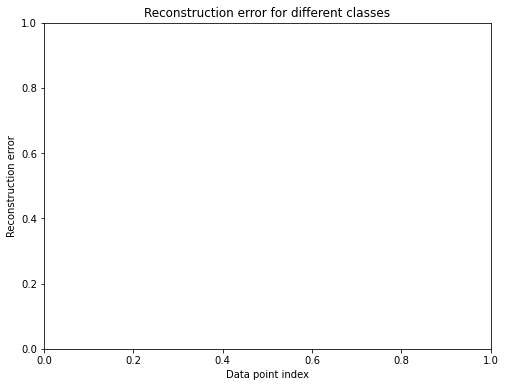

In [16]:
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

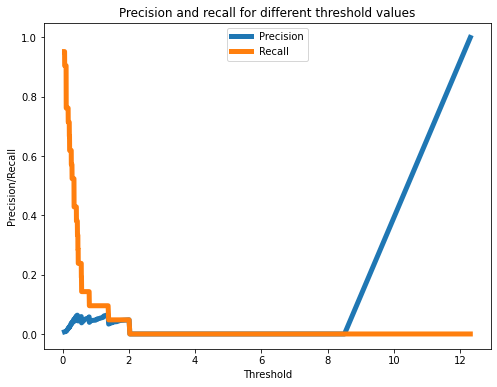

In [17]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision", linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall", linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

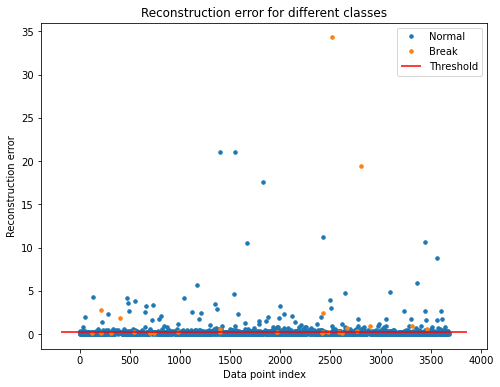

In [18]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)  # 计算平均方差

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')  # 根据True_class即实际的0，1分类
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()


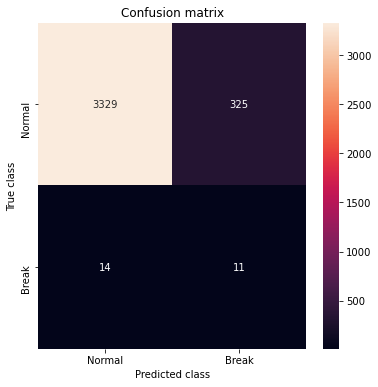

In [19]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

false_pos_rate
[0.00000000e+00 0.00000000e+00 5.47345375e-04 5.47345375e-04
 6.56814450e-03 6.56814450e-03 8.48385331e-03 8.48385331e-03
 1.06732348e-02 1.06732348e-02 1.72413793e-02 1.72413793e-02
 1.91570881e-02 1.91570881e-02 2.46305419e-02 2.46305419e-02
 2.54515599e-02 2.54515599e-02 2.57252326e-02 2.57252326e-02
 7.49863164e-02 7.49863164e-02 9.74274767e-02 9.74274767e-02
 1.02353585e-01 1.02353585e-01 1.05090312e-01 1.05090312e-01
 1.09469075e-01 1.09469075e-01 1.13026820e-01 1.13026820e-01
 1.38478380e-01 1.38478380e-01 2.15380405e-01 2.15380405e-01
 2.25779967e-01 2.25779967e-01 2.29337712e-01 2.29337712e-01
 2.48221128e-01 2.48221128e-01 5.15051998e-01 5.15051998e-01
 6.81718664e-01 6.81718664e-01 6.83634373e-01 6.83634373e-01
 7.87903667e-01 7.87903667e-01 1.00000000e+00]
true_pos_rate
[0.   0.04 0.04 0.08 0.08 0.12 0.12 0.16 0.16 0.2  0.2  0.24 0.24 0.28
 0.28 0.32 0.32 0.36 0.36 0.4  0.4  0.44 0.44 0.48 0.48 0.52 0.52 0.56
 0.56 0.6  0.6  0.64 0.64 0.68 0.68 0.72 0.72 0.76

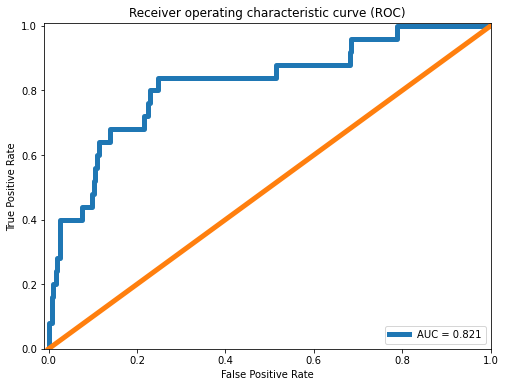

In [20]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate, )
print("false_pos_rate")
print(false_pos_rate)
print("true_pos_rate")
print(true_pos_rate)
print("thresholds")
print(thresholds)
print("roc_auc")
print(roc_auc)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
X_test.shape

(3679, 5, 59)

In [22]:
y_test.shape

(3679,)

In [23]:
lstm_autoencoder.layers[0].input

<tf.Tensor 'lstm_1_input:0' shape=(?, 5, 59) dtype=float32>

In [29]:
import shap

explainer = shap.DeepExplainer(lstm_autoencoder,X_train)

shap_values = explainer.shap_values(X_test)

shap.initjs()



AssertionError: The model output must be a vector or a single value!

In [ ]:

shap.force_plot(explainer.expected_value[0],shap_values[0][0],X_test_scaled)